In [1]:
import re
import os
import glob
import random
from nltk.corpus import stopwords
import nltk

REPLACE_NO_SPACE = re.compile("[._;:!`¦\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
nltk.download('stopwords')  

def preprocess_text(text):
	stop_words = set(stopwords.words('english'))
	text = REPLACE_NO_SPACE.sub("", text)
	text = REPLACE_WITH_SPACE.sub(" ", text)
	text = re.sub(r'\d+', '', text)
	text = text.lower()
	words = text.split()
	return [w for w in words if w not in stop_words]

def load_training_set(percentage_positives, percentage_negatives):
	vocab = set()
	positive_instances = []
	negative_instances = []
	for filename in glob.glob('train/pos/*.txt'):
		if random.random() > percentage_positives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			positive_instances.append(contents)
			vocab = vocab.union(set(contents))
	for filename in glob.glob('train/neg/*.txt'):
		if random.random() > percentage_negatives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			negative_instances.append(contents)
			vocab = vocab.union(set(contents))	
	return positive_instances, negative_instances, vocab

def load_test_set(percentage_positives, percentage_negatives):
	positive_instances = []
	negative_instances = []
	for filename in glob.glob('test/pos/*.txt'):
		if random.random() > percentage_positives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			positive_instances.append(contents)
	for filename in glob.glob('test/neg/*.txt'):
		if random.random() > percentage_negatives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			negative_instances.append(contents)
	return positive_instances, negative_instances
		


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noshitha/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


from collections import defaultdict
import numpy as np

class MultinomialNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.word_probs = {}

    def train(self, pos_train, neg_train, vocab):
        # Calculate priors
        total_docs = len(pos_train) + len(neg_train)
        self.priors['positive'] = len(pos_train) / total_docs
        self.priors['negative'] = len(neg_train) / total_docs

        # Frequency of words in positive and negative training sets
        word_counts_pos = defaultdict(int)
        word_counts_neg = defaultdict(int)

        for doc in pos_train:
            for word in doc:
                word_counts_pos[word] += 1

        for doc in neg_train:
            for word in doc:
                word_counts_neg[word] += 1

        self.word_probs['positive'] = self.calculate_word_probs(word_counts_pos, vocab)
        self.word_probs['negative'] = self.calculate_word_probs(word_counts_neg, vocab)
    
    def calculate_word_probs(self, word_counts, vocab):
        word_probs = {}
        total_words = sum(word_counts.values())

        for word in vocab:
            word_probs[word] = word_counts[word] / total_words if total_words > 0 else 0
        return word_probs

    def test(self, pos_test, neg_test, use_log=False):
        correct_predictions = 0
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0

        for doc_set, true_label in [(pos_test, 'positive'), (neg_test, 'negative')]:
            for doc in doc_set:
                predicted_label = self.classify(doc, use_log)

                # Update confusion matrix
                if predicted_label == true_label:
                    correct_predictions += 1
                    if predicted_label == 'positive':
                        true_positive += 1
                    else:
                        true_negative += 1
                else:
                    if predicted_label == 'positive':
                        false_positive += 1
                    else:
                        false_negative += 1

        accuracy = correct_predictions / (len(pos_test) + len(neg_test))
        precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
        confusion_matrix = {
            'true_positive': true_positive,
            'true_negative': true_negative,
            'false_positive': false_positive,
            'false_negative': false_negative
        }

        return accuracy, precision, recall, confusion_matrix


    def classify(self, doc, use_log=False):
        # Calculating probabilities or log probabilities based on the flag
        if use_log:
            return self.classify_log_probabilities(doc)
        else:
            return self.classify_probabilities(doc)

     def classify_probabilities(self, doc):
         prob_pos = self.priors['positive']
         prob_neg = self.priors['negative']

         for word in doc:
             if word in self.word_probs['positive']:
                 prob_pos *= self.word_probs['positive'][word]
             else:
                 prob_pos *= 1 / (sum(self.word_probs['positive'].values()) + len(self.word_probs['positive']))

            if word in self.word_probs['negative']:
                 prob_neg *= self.word_probs['negative'][word]
             else:
              prob_neg *= 1 / (sum(self.word_probs['negative'].values()) + len(self.word_probs['negative']))

        return 'positive' if prob_pos > prob_neg else 'negative'
    
    def classify_probabilities(self, doc):
        prob_pos = self.priors['positive']
        prob_neg = self.priors['negative']

        for word in doc:
            if word in self.word_probs['positive']:
                prob_pos *= self.word_probs['positive'][word]
            else:
                prob_pos *= 0  # Set probability to 0 for unseen words

            if word in self.word_probs['negative']:
                prob_neg *= self.word_probs['negative'][word]
            else:
                prob_neg *= 0  # Set probability to 0 for unseen words

        return 'positive' if prob_pos > prob_neg else 'negative'


    def classify_log_probabilities(self, doc):
        log_prob_pos = np.log(self.priors['positive'])
        log_prob_neg = np.log(self.priors['negative'])

        for word in doc:
            if word in self.word_probs['positive']:
                log_prob_pos += np.log(self.word_probs['positive'][word])
            else:
                log_prob_pos += np.log(1e-10)

            if word in self.word_probs['negative']:
                log_prob_neg += np.log(self.word_probs['negative'][word])
            else:
                log_prob_neg += np.log(1e-10)

        return 'positive' if log_prob_pos > log_prob_neg else 'negative'


#### Q1 OUTPUT

from utils import load_training_set, load_test_set
#from naive_bayes import MultinomialNaiveBayes

def evaluate_model(percentage_train, percentage_test):
    pos_train, neg_train, vocab = load_training_set(percentage_train, percentage_train)
    pos_test, neg_test = load_test_set(percentage_test, percentage_test)

    # Create and train the model
    model = MultinomialNaiveBayes()
    model.train(pos_train, neg_train, vocab)

    # Evaluate using posterior probabilities
    accuracy, precision, recall, confusion_matrix = model.test(pos_test, neg_test)
    print("Evaluation using posterior probabilities:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix)

    # Evaluate using log-probabilities
    accuracy_log, precision_log, recall_log, confusion_matrix_log = model.test(pos_test, neg_test, use_log=True)
    print("\nEvaluation using log-probabilities:")
    print(f"Accuracy: {accuracy_log:.3f}")
    print(f"Precision: {precision_log:.3f}")
    print(f"Recall: {recall_log:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix_log)

if __name__ == "__main__":
    evaluate_model(0.2, 0.2)

### Q2 LAPLACE

from collections import defaultdict
import numpy as np

class MultinomialNaiveBayes(alpha):
    def __init__(self, alpha):
        self.priors = {}
        self.word_probs = {}
        self.alpha = alpha

    def train(self, pos_train, neg_train, vocab):
        # Calculate priors
        total_docs = len(pos_train) + len(neg_train)
        self.priors['positive'] = len(pos_train) / total_docs
        self.priors['negative'] = len(neg_train) / total_docs

        # Count word occurrences in positive and negative training sets
        word_counts_pos = defaultdict(int)
        word_counts_neg = defaultdict(int)

        for doc in pos_train:
            for word in doc:
                word_counts_pos[word] += 1

        for doc in neg_train:
            for word in doc:
                word_counts_neg[word] += 1

        self.word_probs['positive'] = self.calculate_word_probs(word_counts_pos, vocab)
        self.word_probs['negative'] = self.calculate_word_probs(word_counts_neg, vocab)

    def calculate_word_probs(self, word_counts, vocab):
        word_probs = {}
        total_words = sum(word_counts.values()) + len(vocab)

        for word in vocab:
            word_probs[word] = (word_counts[word] + self.alpha) / (total_words + self.alpha * len(vocab))

        return word_probs

    def test(self, pos_test, neg_test):
        correct_predictions = 0
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0

        for doc_set, true_label in [(pos_test, 'positive'), (neg_test, 'negative')]:
            for doc in doc_set:
                predicted_label = self.classify(doc)

                # Update confusion matrix
                if predicted_label == true_label:
                    correct_predictions += 1
                    if predicted_label == 'positive':
                        true_positive += 1
                    else:
                        true_negative += 1
                else:
                    if predicted_label == 'positive':
                        false_positive += 1
                    else:
                        false_negative += 1

        accuracy = correct_predictions / (len(pos_test) + len(neg_test))
        precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
        confusion_matrix = {
            'true_positive': true_positive,
            'true_negative': true_negative,
            'false_positive': false_positive,
            'false_negative': false_negative
        }

        return accuracy, precision, recall, confusion_matrix

    def classify(self, doc):
        prob_pos = self.priors['positive']
        prob_neg = self.priors['negative']

        for word in doc:
            if word in self.word_probs['positive']:
                prob_pos *= self.word_probs['positive'][word]
            else:
                prob_pos *= 1 / (sum(self.word_probs['positive'].values()) + len(self.word_probs['positive']))

            if word in self.word_probs['negative']:
                prob_neg *= self.word_probs['negative'][word]
            else:
                prob_neg *= 1 / (sum(self.word_probs['negative'].values()) + len(self.word_probs['negative']))

        return 'positive' if prob_pos > prob_neg else 'negative'

### Q2 output

import matplotlib.pyplot as plt

def evaluate_model_with_alpha(pos_train, neg_train, pos_test, neg_test, vocab, alpha_values):
    results = {'alpha': [], 'accuracy': [], 'precision': [], 'recall': []}

    for alpha in alpha_values:
        model = MultinomialNaiveBayes(alpha=alpha)
        model.train(pos_train, neg_train, vocab)

        accuracy, precision, recall, _ = model.test(pos_test, neg_test)
        results['alpha'].append(alpha)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)

    return results


def plot_results(results):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(results['alpha'], results['accuracy'], marker='o')
    plt.xscale('log')
    plt.title('Model Accuracy vs. Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(results['alpha'], results['precision'], label='Precision', marker='o')
    plt.plot(results['alpha'], results['recall'], label='Recall', marker='o')
    plt.xscale('log')
    plt.title('Model Precision and Recall vs. Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 100, 1000]
    percentage_train = 0.2
    percentage_test = 0.2

    pos_train, neg_train, vocab_train = load_training_set(percentage_train, percentage_train)
    pos_test, neg_test = load_test_set(percentage_test, percentage_test)

    # Evaluate with α = 1
    model_alpha_1 = MultinomialNaiveBayes(alpha=1)
    model_alpha_1.train(pos_train, neg_train, vocab_train)
    accuracy_1, _, _, _ = model_alpha_1.test(pos_test, neg_test)

    print(f"Evaluation with α = 1:")
    print(f"Accuracy: {accuracy_1:.3f}")
    
    results = evaluate_model_with_alpha(pos_train, neg_train, pos_test, neg_test, vocab_train, alpha_values)
    plot_results(results)

## UPDATED WHOLE CODE

In [70]:
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_training_set, load_test_set

class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.priors = {}
        self.word_probs = {}
        self.alpha = alpha

    def train(self, pos_train, neg_train, vocab):
        # Calculate priors
        total_docs = len(pos_train) + len(neg_train)
        self.priors['positive'] = len(pos_train) / total_docs
        self.priors['negative'] = len(neg_train) / total_docs

        # Count word occurrences in positive and negative training sets
        word_counts_pos = defaultdict(int)
        word_counts_neg = defaultdict(int)

        for doc in pos_train:
            for word in doc:
                word_counts_pos[word] += 1

        for doc in neg_train:
            for word in doc:
                word_counts_neg[word] += 1

        self.word_probs['positive'] = self.calculate_word_probs(word_counts_pos, vocab)
        self.word_probs['negative'] = self.calculate_word_probs(word_counts_neg, vocab)

    def calculate_word_probs(self, word_counts, vocab):
        word_probs = {}
        total_words = sum(word_counts.values()) + len(vocab)

        for word in vocab:
            if word:
                word_probs[word] = (word_counts[word] + self.alpha) / (total_words + self.alpha * len(vocab))
            else:
                word_probs[word] = 0

        return word_probs

    def test(self, pos_test, neg_test, use_log=False):
        correct_predictions = 0
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0

        for doc_set, true_label in [(pos_test, 'positive'), (neg_test, 'negative')]:
            for doc in doc_set:
                predicted_label = self.classify(doc, use_log)

                # Update confusion matrix
                if predicted_label == true_label:
                    correct_predictions += 1
                    if predicted_label == 'positive':
                        true_positive += 1
                    else:
                        true_negative += 1
                else:
                    if predicted_label == 'positive':
                        false_positive += 1
                    else:
                        false_negative += 1

        accuracy = correct_predictions / (len(pos_test) + len(neg_test))
        precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
        confusion_matrix = {
            'true_positive': true_positive,
            'true_negative': true_negative,
            'false_positive': false_positive,
            'false_negative': false_negative
        }

        return accuracy, precision, recall, confusion_matrix

    def classify(self, doc, use_log=False):
        # Calculating probabilities or log probabilities based on the flag
        if use_log:
            return self.classify_log_probabilities(doc)
        else:
            return self.classify_probabilities(doc)
    
    
    def classify_probabilities(self, doc):
        prob_pos = self.priors['positive']
        prob_neg = self.priors['negative']

        for word in doc:
            if word in self.word_probs['positive']:
                prob_pos *= self.word_probs['positive'][word]
            else:
                prob_pos *= 0  # Set probability to 0 for unseen words

            if word in self.word_probs['negative']:
                prob_neg *= self.word_probs['negative'][word]
            else:
                prob_neg *= 0  # Set probability to 0 for unseen words

        return 'positive' if prob_pos > prob_neg else 'negative'


    def classify_log_probabilities(self, doc):
        log_prob_pos = np.log(self.priors['positive'])
        log_prob_neg = np.log(self.priors['negative'])

        for word in doc:
            if word in self.word_probs['positive']:
                log_prob_pos += np.log(self.word_probs['positive'][word] + 1e-10)
            else:
                log_prob_pos += np.log(1e-10)

            if word in self.word_probs['negative']:
                log_prob_neg += np.log(self.word_probs['negative'][word] + 1e-10)
            else:
                log_prob_neg += np.log(1e-10)

        return 'positive' if log_prob_pos > log_prob_neg else 'negative'
    
    def plot_results(results):
        plt.figure(figsize=(10, 6))

        plt.subplot(2, 1, 1)
        plt.plot(results['alpha'], results['accuracy'], marker='o')
        plt.xscale('log')
        plt.title('Model Accuracy vs. Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(results['alpha'], results['precision'], label='Precision', marker='o')
        plt.plot(results['alpha'], results['recall'], label='Recall', marker='o')
        plt.xscale('log')
        plt.title('Model Precision and Recall vs. Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, confusion_matrix):
        labels = ['Positive', 'Negative']
        cm_array = np.array([[confusion_matrix['true_positive'], confusion_matrix['false_positive']],
                             [confusion_matrix['false_negative'], confusion_matrix['true_negative']]])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


## Q1 AND Q2


Evaluation without Laplace Smoothing:
Accuracy: 0.523
Precision: 0.732
Recall: 0.055
Confusion Matrix: {'true_positive': 139, 'true_negative': 2531, 'false_positive': 51, 'false_negative': 2383}


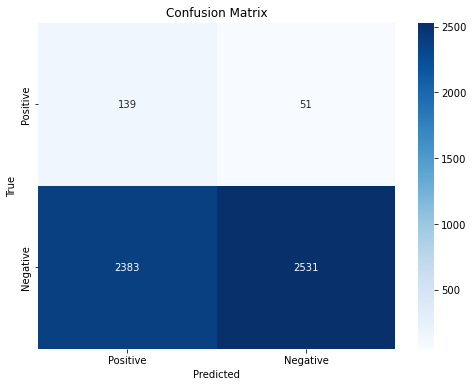


Evaluation using Log Probabilities without Laplace Smoothing:
Accuracy: 0.732
Precision: 0.744
Recall: 0.698
Confusion Matrix: {'true_positive': 1761, 'true_negative': 1975, 'false_positive': 607, 'false_negative': 761}


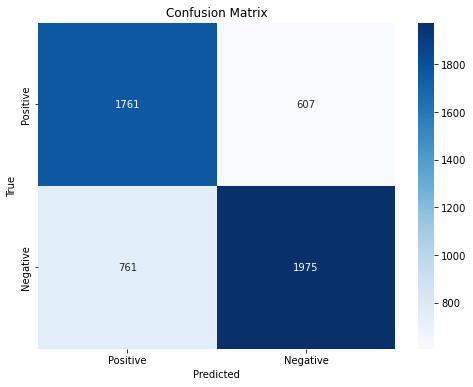


 Q2:

Evaluation with Laplace Smoothing:
Evaluation with α = 1:
Accuracy: 0.822
Precision: 0.863
Recall: 0.822
Confusion Matrix: {'true_positive': 1918, 'true_negative': 2278, 'false_positive': 304, 'false_negative': 604}


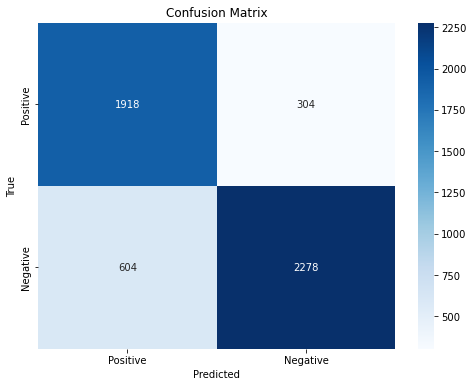

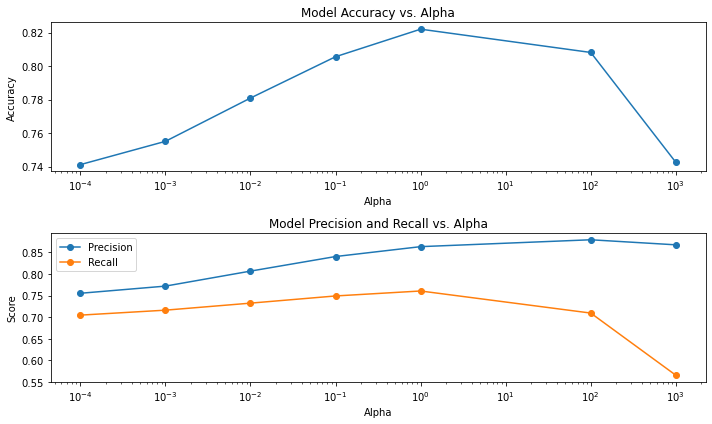

In [82]:
pos_train, neg_train, vocab = load_training_set(0.2, 0.2)
pos_test, neg_test = load_test_set(0.2, 0.2)

model_without_laplace = MultinomialNaiveBayes(alpha=0)
model_without_laplace.train(pos_train, neg_train, vocab)

accuracy, precision, recall, confusion_matrix = model_without_laplace.test(pos_test, neg_test)
print("\nEvaluation without Laplace Smoothing:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Confusion Matrix: {confusion_matrix}")
model_without_laplace.plot_confusion_matrix(confusion_matrix)

model_log_without_laplace = MultinomialNaiveBayes(alpha=0)
model_log_without_laplace.train(pos_train, neg_train, vocab)

accuracy_log, precision_log, recall_log, confusion_matrix_log = model_log_without_laplace.test(pos_test, neg_test, use_log=True)
print("\nEvaluation using Log Probabilities without Laplace Smoothing:")
print(f"Accuracy: {accuracy_log:.3f}")
print(f"Precision: {precision_log:.3f}")
print(f"Recall: {recall_log:.3f}")
print(f"Confusion Matrix: {confusion_matrix_log}")
model_log_without_laplace.plot_confusion_matrix(confusion_matrix_log)


print("\n Q2:")
print("\nEvaluation with Laplace Smoothing:")
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 100, 1000]
# Evaluate with α = 1
model_alpha_1 = MultinomialNaiveBayes(alpha=1)
model_alpha_1.train(pos_train, neg_train, vocab)
accuracy_1, precision_1, recall_1, confusion_matrix_1 = model_alpha_1.test(pos_test, neg_test, use_log=True)

print(f"Evaluation with α = 1:")
print(f"Accuracy: {accuracy_1:.3f}")
print(f"Precision: {precision_1:.3f}")
print(f"Recall: {accuracy_1:.3f}")
print(f"Confusion Matrix: {confusion_matrix_1}")
model_alpha_1.plot_confusion_matrix(confusion_matrix_1)

#results = evaluate_model_with_alpha(pos_train, neg_train, pos_test, neg_test, vocab, alpha_values)

results = {'alpha': [], 'accuracy': [], 'precision': [], 'recall': []}
for alpha in alpha_values:
    model = MultinomialNaiveBayes(alpha=alpha)
    model.train(pos_train, neg_train, vocab)

    accuracy, precision, recall, _ = model.test(pos_test, neg_test, use_log=True)
    results['alpha'].append(alpha)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    
plot_results(results)

## Q3

Q.3 Results:
Accuracy: 0.824
Precision: 0.863
Recall: 0.771
Confusion Matrix:


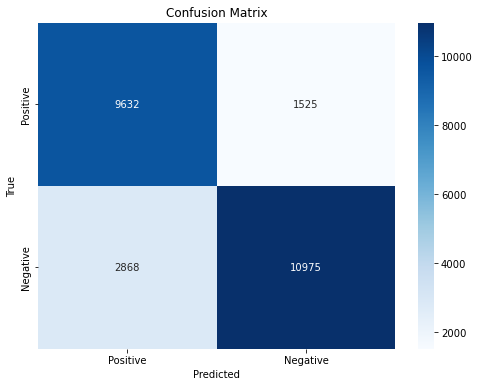

In [77]:
# Load 100% of the training and test sets
pos_train, neg_train, vocab_train = load_training_set(1.0, 1.0)
pos_test, neg_test = load_test_set(1.0, 1.0)

# Initialize and train the model with the optimal α =1
model_q3 = MultinomialNaiveBayes(alpha=1)
model_q3.train(pos_train, neg_train, vocab_train)

# Evaluate the model
accuracy_q3, precision_q3, recall_q3, confusion_matrix_q3 = model_q3.test(pos_test, neg_test, use_log=True)

# Report results
print("Q.3 Results:")
print(f"Accuracy: {accuracy_q3:.3f}")
print(f"Precision: {precision_q3:.3f}")
print(f"Recall: {recall_q3:.3f}")
print(f"Confusion Matrix: {confusion_matrix_q3}")
model_log_without_laplace.plot_confusion_matrix(confusion_matrix_q3)

## Q4

Q.4 Results:
Accuracy: 0.827
Precision: 0.861
Recall: 0.778
Confusion Matrix:


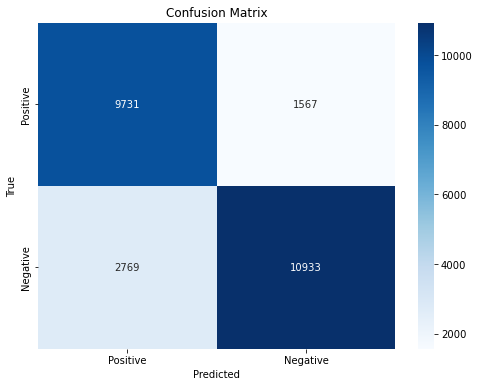


Comparison with Q.3:
Accuracy Change: 0.002
Precision Change: -0.002
Recall Change: 0.008


In [78]:
# Load 50% of the training set and 100% of the test set
pos_train_50, neg_train_50, vocab_train_50 = load_training_set(0.5, 0.5)

# Initialize and train the model with the optimal α from the previous experiment
model_q4 = MultinomialNaiveBayes(alpha=1)
model_q4.train(pos_train_50, neg_train_50, vocab_train_50)

# Evaluate the model
accuracy_q4, precision_q4, recall_q4, confusion_matrix_q4 = model_q4.test(pos_test, neg_test, use_log=True)

# Report results
print("Q.4 Results:")
print(f"Accuracy: {accuracy_q4:.3f}")
print(f"Precision: {precision_q4:.3f}")
print(f"Recall: {recall_q4:.3f}")
print(f"Confusion Matrix: {confusion_matrix_q4}")
model_log_without_laplace.plot_confusion_matrix(confusion_matrix_q4)

# Compare with Q.3
print("\nComparison with Q.3:")
print(f"Accuracy Change: {accuracy_q4 - accuracy_q3:.3f}")
print(f"Precision Change: {precision_q4 - precision_q3:.3f}")
print(f"Recall Change: {recall_q4 - recall_q3:.3f}")

### Q6

Q.6 Results:
Accuracy: 0.512
Precision: 0.987
Recall: 0.025
Confusion Matrix:


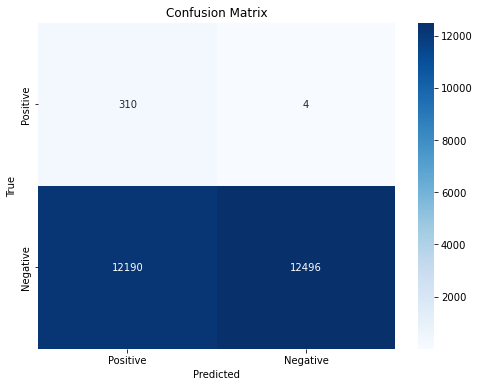


Comparison with Q.4:
Accuracy Change: -0.314
Precision Change: 0.126
Recall Change: -0.754


In [79]:
# Load 10% of positive and 50% of negative training instances
pos_train_unbalanced, neg_train_unbalanced, vocab_train_unbalanced = load_training_set(0.1, 0.5)

# Initialize and train the model with the optimal α from the previous experiment
model_q6 = MultinomialNaiveBayes(alpha=1)
model_q6.train(pos_train_unbalanced, neg_train_unbalanced, vocab_train_unbalanced)

# Evaluate the model
accuracy_q6, precision_q6, recall_q6, confusion_matrix_q6 = model_q6.test(pos_test, neg_test, use_log=True)

# Report results
print("Q.6 Results:")
print(f"Accuracy: {accuracy_q6:.3f}")
print(f"Precision: {precision_q6:.3f}")
print(f"Recall: {recall_q6:.3f}")
print(f"Confusion Matrix: {confusion_matrix_q6}")
model_log_without_laplace.plot_confusion_matrix(confusion_matrix_q6)

# Compare with Q.4
print("\nComparison with Q.4:")
print(f"Accuracy Change: {accuracy_q6 - accuracy_q4:.3f}")
print(f"Precision Change: {precision_q6 - precision_q4:.3f}")
print(f"Recall Change: {recall_q6 - recall_q4:.3f}")
